# Sessa Empirical Estimator Python Implementation

### Introduction

Medication adherence plays a crucial role in ensuring the effectiveness of treatments, particularly for chronic diseases where consistent medication intake is required. Understanding patient adherence patterns can help healthcare professionals develop targeted interventions to improve medication persistence and effectiveness. One way to analyze these patterns is through clustering techniques, which group patients based on similarities in their medication event intervals.

The Sessa Empirical Estimator (SEE) is a clustering-based method designed to segment patients based on their refill behavior, allowing researchers to identify distinct adherence profiles. This approach was initially implemented in R, and in this notebook, we translate it into Python to provide a reproducible and scalable implementation. By leveraging Python’s data science ecosystem, we can apply SEE efficiently and explore its effectiveness in classifying patients based on their refill intervals.

## **Import Libraries**

This notebook utilizes various libraries for data processing, visualization, and clustering in implementing the **Sessa Empirical Estimator (SEE)**.  

### **1. System & Environment**  
- `os.environ['OMP_NUM_THREADS'] = '1'` → Limits CPU usage for efficiency.  
- `warnings.simplefilter("ignore")` → Suppresses warnings for cleaner output.  

### **2. Data Handling**  
- `pandas (pd)` → Manages structured data with **DataFrames**.  
- `numpy (np)` → Performs numerical operations and statistical analysis.  

### **3. Visualization**  
- `matplotlib.pyplot (plt)` → Creates static and interactive plots.  
- `seaborn (sns)` → Enhances statistical visualizations.  

### **4. Statistical & Machine Learning**  
- `gaussian_kde` → Computes **kernel density estimation (KDE)** for distribution visualization.  
- `KMeans, DBSCAN` → Implements clustering algorithms.  
- `StandardScaler` → Standardizes data for better clustering.  
- `silhouette_score` → Evaluates clustering performance.  

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.simplefilter("ignore")

## **Load Dataset**

In [2]:
example_pats = pd.read_csv('../data/med_events.csv')
example_pats.head()

,PATIENT_ID,DATE,PERDAY,CATEGORY,DURATION
0,1,04/26/2033,4,medA,50
1,1,07/04/2033,4,medB,30
2,1,08/03/2033,4,medB,30
3,1,08/17/2033,4,medB,30
4,1,10/13/2033,4,medB,30


## **Rename Columns**

🔹 **PATIENT_ID** → `pnr`  
🔹 **DATE** → `eksd`  
🔹 **PERDAY** → `perday`  
🔹 **CATEGORY** → `ATC`  
🔹 **DURATION** → `dur_original` 


In [3]:
tidy = example_pats
tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]


## **Convert Date Column to Datetime and sort values**

In [4]:
tidy['eksd'] = pd.to_datetime(tidy['eksd'])
tidy = tidy.sort_values(['pnr', 'eksd'])
tidy.head()

,pnr,eksd,perday,ATC,dur_original
0,1,2033-04-26,4,medA,50
1,1,2033-07-04,4,medB,30
2,1,2033-08-03,4,medB,30
3,1,2033-08-17,4,medB,30
4,1,2033-10-13,4,medB,30


## **Exploratory Data Analysis**

### Inspect the data 

#### Dataset structure

In [5]:
print(tidy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pnr           1080 non-null   int64         
 1   eksd          1080 non-null   datetime64[ns]
 2   perday        1080 non-null   int64         
 3   ATC           1080 non-null   object        
 4   dur_original  1080 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 42.3+ KB
None


#### Summary statistics

In [6]:
print(tidy.describe())

               pnr                 eksd       perday  dur_original
count  1080.000000                 1080  1080.000000    1080.00000
mean     50.934259  2038-01-29 22:02:40     3.762963      47.37963
min       1.000000  2030-09-06 00:00:00     2.000000      20.00000
25%      24.000000  2035-06-03 06:00:00     2.000000      30.00000
50%      51.500000  2037-09-03 12:00:00     4.000000      50.00000
75%      78.000000  2041-05-05 00:00:00     4.000000      50.00000
max     100.000000  2044-09-03 00:00:00    20.000000     150.00000
std      29.999542                  NaN     2.139552      22.08091


#### Missing Values

In [7]:
print(tidy.isna().sum())

pnr             0
eksd            0
perday          0
ATC             0
dur_original    0
dtype: int64


### Distribution of Medication Duration  

Visualizing the distribution of `dur_original` to understand its spread and density.  

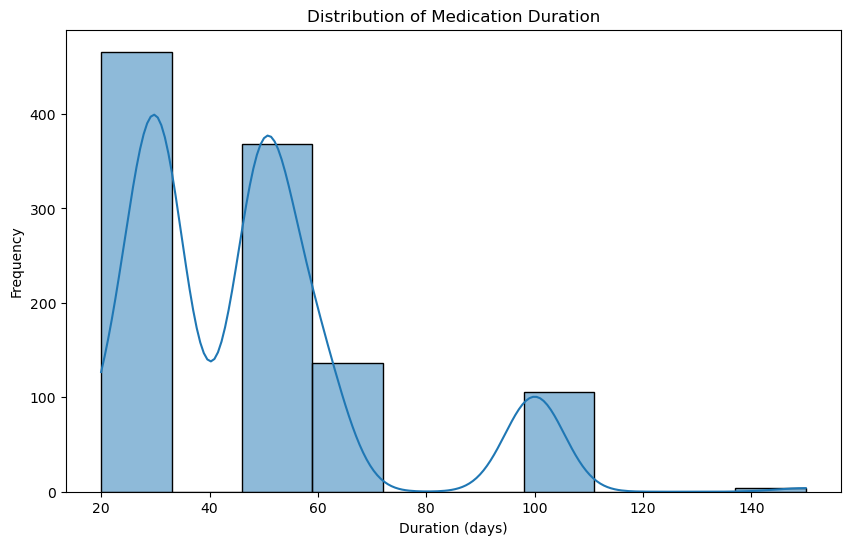

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(tidy['dur_original'], bins=10, kde=True)
plt.title('Distribution of Medication Duration')
plt.xlabel('Duration (days)')
plt.ylabel('Frequency')
plt.show()

### Prescription Distribution by Medication Type  

Visualizing the count of prescriptions for each medication category (`ATC`).  

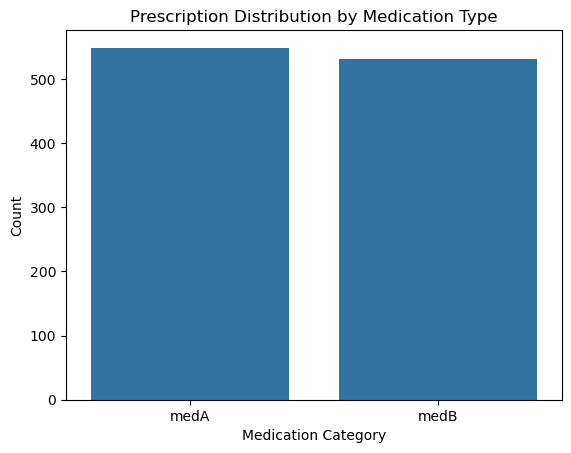

In [9]:
sns.countplot(x='ATC', data=tidy)
plt.title('Prescription Distribution by Medication Type')
plt.xlabel('Medication Category')
plt.ylabel('Count')
plt.show()

### Daily Dosage Analysis

Explore the distribution of daily dosages(PERDAY). To see the differences between medA and medB (e.g., medB has higher dosages).

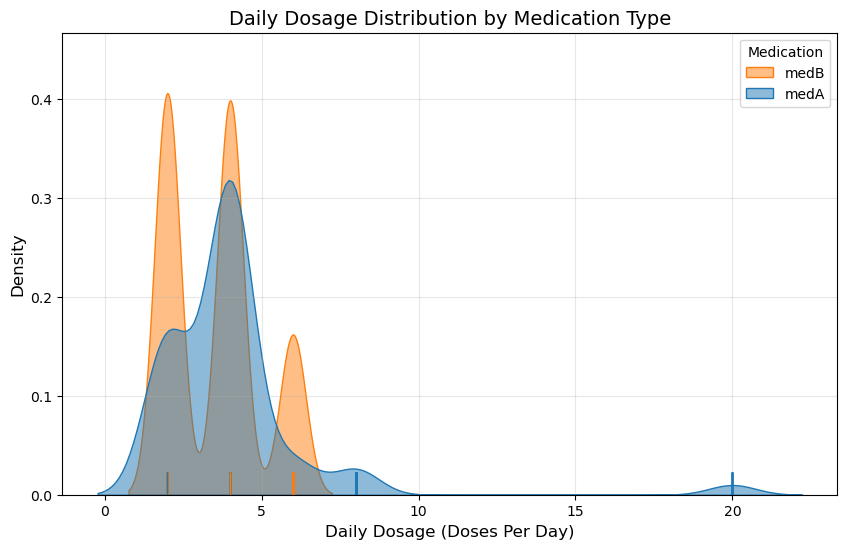

In [10]:
# Create density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=tidy,
    x='perday',
    hue='ATC',
    fill=True,
    common_norm=False,  # Show densities separately (not normalized to total area=1)
    alpha=0.5,
    palette=['#1f77b4', '#ff7f0e']  # Colors for medA/medB
)

# Add rugplot to show individual observations
sns.rugplot(
    data=tidy,
    x='perday',
    hue='ATC',
    palette=['#1f77b4', '#ff7f0e'],
    height=0.05,
    legend=False
)

plt.title('Daily Dosage Distribution by Medication Type', fontsize=14)
plt.xlabel('Daily Dosage (Doses Per Day)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Medication', labels=['medB', 'medA'])
plt.grid(alpha=0.3)
plt.show()

### Silhoutte Analysis
To determine the optimal number of clusters

For n_clusters = 2, the average silhouette_score is: 0.6151
For n_clusters = 3, the average silhouette_score is: 0.4779
For n_clusters = 4, the average silhouette_score is: 0.5147
For n_clusters = 5, the average silhouette_score is: 0.5420
For n_clusters = 6, the average silhouette_score is: 0.6932
For n_clusters = 7, the average silhouette_score is: 0.6906
For n_clusters = 8, the average silhouette_score is: 0.7926
For n_clusters = 9, the average silhouette_score is: 0.8384
For n_clusters = 10, the average silhouette_score is: 0.8480


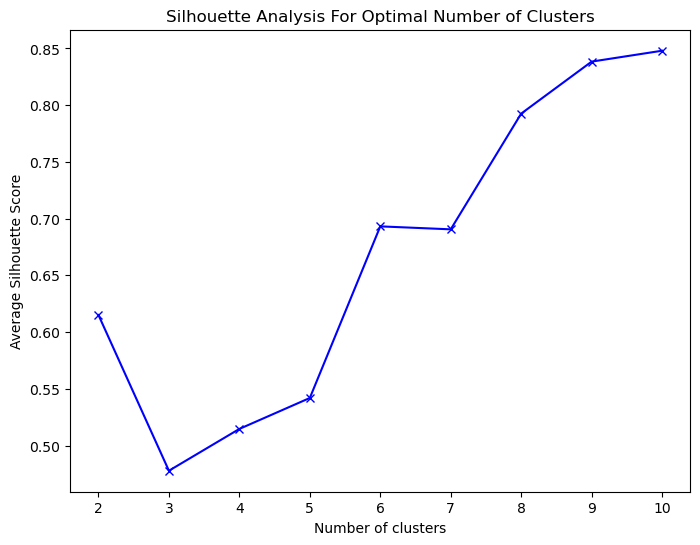

Optimal number of clusters: 10


In [11]:
# Select features for clustering.
# Here we choose 'perday' (daily dosage) and 'dur_original' (duration)
X = tidy[['perday', 'dur_original']].values

# Scale features for better performance of KMeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Range of clusters to try
range_n_clusters = range(2, 11)
silhouette_avg_scores = []

# Loop over the number of clusters to evaluate the silhouette score
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is: {silhouette_avg:.4f}")

# Plot the silhouette scores to visually inspect the optimal number of clusters
plt.figure(figsize=(8, 6))
plt.plot(list(range_n_clusters), silhouette_avg_scores, 'bx-')
plt.xlabel("Number of clusters")
plt.ylabel("Average Silhouette Score")
plt.title("Silhouette Analysis For Optimal Number of Clusters")
plt.show()

# Determine the optimal number of clusters as the one with the highest silhouette score
optimal_n_clusters = list(range_n_clusters)[np.argmax(silhouette_avg_scores)]
print(f"Optimal number of clusters: {optimal_n_clusters}")


## **Sessa Empirical Estimator (K-Means)**

In [12]:
def See(arg1, tidy):
    # Filter data for specific ATC code
    c09ca01 = tidy[tidy['ATC'] == arg1].copy()
    drug_see_p0 = c09ca01.copy()
    drug_see_p1 = c09ca01.copy()
    
    # Create lagged column and process data (Fixed)
    drug_see_p1 = drug_see_p1.sort_values(['pnr', 'eksd'])
    drug_see_p1['prev_eksd'] = drug_see_p1.groupby('pnr')['eksd'].shift(1)
    
    # Remove NAs and sample one row per patient (Fixed)
    drug_see_p1 = drug_see_p1.dropna(subset=['prev_eksd'])
    drug_see_p1 = drug_see_p1.groupby('pnr').sample(1, random_state=123)

    # Select columns and calculate interval
    drug_see_p1 = drug_see_p1[['pnr', 'eksd', 'prev_eksd']]
    drug_see_p1['event.interval'] = (drug_see_p1['eksd'] - 
                                    drug_see_p1['prev_eksd']).dt.days
    
    # Calculate ECDF (needed for clustering)
    x = np.sort(drug_see_p1['event.interval'])
    y = np.arange(1, len(x) + 1) / len(x)
    dfper = pd.DataFrame({'x': x, 'y': y})
    
    # Retain 80% of ECDF (needed for clustering)
    dfper = dfper[dfper['y'] <= 0.8]

    # optimal # of clusters
    max_cluster = optimal_n_clusters
    
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=max_cluster, random_state=1234, n_init=10)
    dfper['cluster'] = kmeans.fit_predict(dfper[['x']])
    
    # Calculate cluster statistics (Fixed log issue)
    cluster_stats = pd.DataFrame()
    for cluster in range(max_cluster):
        cluster_data = np.log(dfper[dfper['cluster'] == cluster]['x'] + 1e-9)  # Avoid log(0)
        stats_dict = {
            'Cluster': cluster,
            'Minimum': np.exp(cluster_data.min()),
            'Maximum': np.exp(cluster_data.max()),
            'Median': np.exp(cluster_data.median())
        }
        cluster_stats = pd.concat([cluster_stats, pd.DataFrame([stats_dict])], 
                                  ignore_index=True)
    
    # Process results
    results = pd.merge(
        drug_see_p1,
        cluster_stats,
        how='cross'
    )
    
    results['Final_cluster'] = np.where(
        (results['event.interval'] >= results['Minimum']) & 
        (results['event.interval'] <= results['Maximum']),
        results['Cluster'],
        np.nan
    )
    
    results = results.dropna(subset=['Final_cluster'])
    
    # Get most frequent cluster
    t1 = results['Cluster'].mode().iloc[0]
    t1_merged = results[results['Cluster'] == t1][['Cluster', 'pnr', 'Median']].iloc[0]
    
    # Final processing
    drug_see_p1 = pd.merge(drug_see_p1, results[['pnr', 'Median', 'Cluster']], 
                          on='pnr', how='left')
    drug_see_p1['Median'] = drug_see_p1['Median'].fillna(t1_merged['Median'])
    drug_see_p1['Cluster'] = drug_see_p1['Cluster'].fillna('0')
    drug_see_p1['test'] = round(drug_see_p1['event.interval'] - 
                               drug_see_p1['Median'], 1)
    
    drug_see_p3 = drug_see_p1[['pnr', 'Median', 'Cluster']]
    
    # Final merge and processing
    drug_see_p0 = pd.merge(drug_see_p0, drug_see_p3, on='pnr', how='left')
    drug_see_p0['Median'] = pd.to_numeric(drug_see_p0['Median'])
    drug_see_p0['Median'] = drug_see_p0['Median'].fillna(t1_merged['Median'])
    drug_see_p0['Cluster'] = drug_see_p0['Cluster'].fillna(0)
    
    return drug_see_p0


## **Sessa Empirical Estimator (DBScan)**

In [28]:
def See_dbscan(arg1, tidy):
    """
    Returns:
      - drug_see_p0: Original data with cluster assignments.
      - dfper: ECDF dataframe with clusters.
      - noise_percentage: Percentage of noise points in DBSCAN.
    """
    # Filter data for specific ATC code
    c09ca01 = tidy[tidy['ATC'] == arg1].copy()
    drug_see_p0 = c09ca01.copy()
    drug_see_p1 = c09ca01.copy()
    
    # Create lagged column and process data
    drug_see_p1 = drug_see_p1.sort_values(['pnr', 'eksd'])
    drug_see_p1['prev_eksd'] = drug_see_p1.groupby('pnr')['eksd'].shift(1)
    
    # Remove rows with no previous event and sample one row per patient
    drug_see_p1 = drug_see_p1.dropna(subset=['prev_eksd'])
    drug_see_p1 = drug_see_p1.groupby('pnr').sample(1, random_state=123)
    
    # Select columns and calculate the interval (in days)
    drug_see_p1 = drug_see_p1[['pnr', 'eksd', 'prev_eksd']]
    drug_see_p1['event.interval'] = (drug_see_p1['eksd'] - drug_see_p1['prev_eksd']).dt.days
    
    # Calculate ECDF on all event intervals and then restrict to lower 80%
    x = np.sort(drug_see_p1['event.interval'])
    y = np.arange(1, len(x) + 1) / len(x)
    dfper = pd.DataFrame({'x': x, 'y': y})
    dfper = dfper[dfper['y'] <= 0.8]
    
    # Perform DBSCAN clustering (with scaling)
    X = dfper[['x']].values
    X_scaled = StandardScaler().fit_transform(X)  # Scale data for DBSCAN
    
    #manual parameters
    dbscan = DBSCAN(eps=0.1, min_samples=2)  # Adjusted parameters ////////////////////////////////////////////////////////////////////////////////
    dfper['cluster'] = dbscan.fit_predict(X_scaled)
    
    # Calculate noise percentage
    noise_count = (dfper['cluster'] == -1).sum()
    noise_percentage = (noise_count / len(dfper)) * 100
    print(f"Noise points: {noise_count} ({noise_percentage:.2f}%)")
    
    # Use only clusters that are not noise (i.e. exclude label -1)
    unique_clusters = [c for c in dfper['cluster'].unique() if c != -1]
    
    # Compute cluster statistics based on dfper (the lower 80% of the data)
    cluster_stats = pd.DataFrame()
    for cluster in unique_clusters:
        cluster_data = dfper[dfper['cluster'] == cluster]['x']
        if not cluster_data.empty:
            # Use a log transformation to reduce skew (adding a small constant to avoid log(0))
            cluster_data_log = np.log1p(cluster_data)
            stats_dict = {
                'Cluster': cluster,
                'Minimum': np.exp(cluster_data_log.min()),
                'Maximum': np.exp(cluster_data_log.max()),
                'Median': np.exp(cluster_data_log.median())
            }
            cluster_stats = pd.concat([cluster_stats, pd.DataFrame([stats_dict])], ignore_index=True)
    
    if cluster_stats.empty:
        raise ValueError("No clusters found by DBSCAN. Check your DBSCAN parameters or input data.")
    
    # Function to assign a cluster (and its median) to an event.interval
    def assign_cluster(event_interval, cluster_stats):
        # Look for clusters where event_interval falls within [Minimum, Maximum]
        possible = cluster_stats[(cluster_stats['Minimum'] <= event_interval) & 
                                 (cluster_stats['Maximum'] >= event_interval)]
        if not possible.empty:
            # If multiple clusters match, choose the one whose median is closest
            possible = possible.copy()
            possible['diff'] = abs(possible['Median'] - event_interval)
            assigned_row = possible.sort_values('diff').iloc[0]
            return assigned_row['Cluster'], assigned_row['Median']
        else:
            # If none match, assign the cluster with the closest median overall
            cluster_stats_copy = cluster_stats.copy()
            cluster_stats_copy['diff'] = abs(cluster_stats_copy['Median'] - event_interval)
            assigned_row = cluster_stats_copy.sort_values('diff').iloc[0]
            return assigned_row['Cluster'], assigned_row['Median']
    
    # Apply the assign_cluster function to each row in drug_see_p1
    assignments = drug_see_p1['event.interval'].apply(lambda x: assign_cluster(x, cluster_stats))
    # Convert the assignments (a Series of tuples) into a DataFrame with two new columns
    assignments_df = pd.DataFrame(assignments.tolist(), index=drug_see_p1.index, 
                                  columns=['Assigned_Cluster', 'Assigned_Median'])
    
    # Merge these assignments back into the event data
    drug_see_p1 = pd.concat([drug_see_p1, assignments_df], axis=1)
    drug_see_p1['test'] = round(drug_see_p1['event.interval'] - drug_see_p1['Assigned_Median'], 1)
    
    # Prepare a DataFrame with the clustering information to merge back into the full data
    drug_see_p3 = drug_see_p1[['pnr', 'Assigned_Median', 'Assigned_Cluster']]
    
    # Final merge: attach cluster assignments to the original data
    drug_see_p0 = pd.merge(drug_see_p0, drug_see_p3, on='pnr', how='left')
    drug_see_p0['Assigned_Median'] = pd.to_numeric(drug_see_p0['Assigned_Median'])
    # Fill any missing assignments with the first cluster's median (as a fallback)
    drug_see_p0['Assigned_Median'] = drug_see_p0['Assigned_Median'].fillna(cluster_stats['Median'].iloc[0])
    drug_see_p0['Assigned_Cluster'] = drug_see_p0['Assigned_Cluster'].fillna(0)
    
    # Optionally, rename the columns for clarity
    drug_see_p0 = drug_see_p0.rename(columns={'Assigned_Median': 'Median', 
                                                'Assigned_Cluster': 'Cluster'})
    
    # Return both the full dataset with cluster assignments and the ECDF dataframe from DBSCAN
    return drug_see_p0, dfper


## Visualization Function

### K-MEANS

In [14]:
def compute_event_intervals_see(data):
    """Helper function to compute event intervals using same logic as See()"""
    df = data.copy()
    # Sort by patient and date
    df = df.sort_values(['pnr', 'eksd'])
    # Create previous date column
    df['prev_eksd'] = df.groupby('pnr')['eksd'].shift(1)
    # Remove rows with no previous date
    df = df.dropna(subset=['prev_eksd'])
    # Sample one row per patient
    sampled = df.groupby('pnr', group_keys=False).sample(1, random_state=123)
    # Calculate interval in days
    sampled['event.interval'] = (sampled['eksd'] - sampled['prev_eksd']).dt.days
    return sampled['event.interval'].tolist()

def visualization(medA_data, medB_data):
    # Compute event intervals for both medications
    medA_intervals = compute_event_intervals_see(medA_data)
    medB_intervals = compute_event_intervals_see(medB_data)
    
    # Process valid intervals and log-transform
    medA_valid = [iv for iv in medA_intervals if iv > 0]
    medB_valid = [iv for iv in medB_intervals if iv > 0]
    
    # Calculate log values for both medications
    medA_log = np.log(medA_valid) if medA_valid else []
    medB_log = np.log(medB_valid) if medB_valid else []
    
    # Calculate global y-axis limits (density values)
    all_densities = []
    if medA_valid:
        kde_A = gaussian_kde(medA_log)
        x_vals_A = np.linspace(np.min(medA_log), np.max(medA_log), 1000)
        all_densities.extend(kde_A(x_vals_A))
    if medB_valid:
        kde_B = gaussian_kde(medB_log)
        x_vals_B = np.linspace(np.min(medB_log), np.max(medB_log), 1000)
        all_densities.extend(kde_B(x_vals_B))
    
    if not all_densities:
        print("No valid intervals for either medication. Skipping plots.")
        return None
    
    global_y_min = 0  # Density cannot be negative
    global_y_max = np.max(all_densities)  # Maximum density value across both medications
    
    # Create figure and axes grid
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    
    # Plot configurations
    plot_configs = [
        ('80% ECDF', 0, lambda x: x[x['y'] <= 0.8]),
        ('100% ECDF', 1, lambda x: x),
        ('Log Interval Density', 2, None)
    ]
    
    # Plot first two rows (ECDFs)
    for row_idx, (title, row, filter_fn) in enumerate(plot_configs[:2]):
        for col_idx, (intervals, med_name) in enumerate(zip([medA_intervals, medB_intervals], ['medA', 'medB'])):
            if not intervals:
                continue
                
            ax = axes[row, col_idx]
            x = np.sort(intervals)
            y = np.arange(1, len(x)+1) / len(x)
            df = pd.DataFrame({'x': x, 'y': y})
            
            if filter_fn:
                df = filter_fn(df)
                
            ax.plot(df['x'], df['y'], color='blue')
            ax.set_title(f'{med_name} - {title}')
            ax.set_xlabel('Days')
            ax.set_ylabel('ECDF')
            ax.grid(True)

    # Plot density row with uniform y-axis
    for col_idx, (intervals, med_name) in enumerate(zip([medA_intervals, medB_intervals], ['medA', 'medB'])):
        ax = axes[2, col_idx]
        valid_intervals = [iv for iv in intervals if iv > 0]
        
        if not valid_intervals:
            ax.text(0.5, 0.5, 'No valid intervals', ha='center')
            continue
            
        log_vals = np.log(valid_intervals)
        kde = gaussian_kde(log_vals)
        x_vals = np.linspace(np.min(log_vals), np.max(log_vals), 1000)
        y_vals = kde(x_vals)
        
        ax.plot(x_vals, y_vals, color='green')
        ax.set_title(f'{med_name} - Log Interval Density')
        ax.set_xlabel('log(Days)')
        ax.set_ylabel('Density')
        
        # Set uniform y-axis limits
        ax.set_ylim(global_y_min, global_y_max + 0.10)
        ax.grid(True)

    plt.tight_layout()
    return fig

### DBSCAN

In [15]:
def visualization_dbscan(medA_clusters, medB_clusters):
    """3x2 grid with:
       - Row 1: 80% ECDF (clustered)
       - Row 2: 100% ECDF (line plot)
       - Row 3: Histograms
    """
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    
    # --- Row 1: 80% ECDF with Clusters ---
    for idx, (df, med_name) in enumerate(zip([medA_clusters, medB_clusters], ['medA', 'medB'])):
        axes[0, idx].scatter(df['x'], df['y'], c=df['cluster'], cmap='viridis', alpha=0.6)
        axes[0, idx].set_title(f'{med_name} - 80% ECDF (Clusters)')
        axes[0, idx].set_xlabel('Event Interval (Days)')
        axes[0, idx].set_ylabel('ECDF')

    # --- Row 2: 100% ECDF Line Plot ---
    for idx, (df, med_name) in enumerate(zip([medA_clusters, medB_clusters], ['medA', 'medB'])):
        axes[1, idx].plot(df['x'], df['y'], marker='.', linestyle='-', color='orange')
        axes[1, idx].set_title(f'{med_name} - 100% ECDF')
        axes[1, idx].set_xlabel('Event Interval (Days)')
        axes[1, idx].set_ylabel('ECDF')

    # --- Row 3: Histograms ---
    for idx, (df, med_name) in enumerate(zip([medA_clusters, medB_clusters], ['medA', 'medB'])):
        axes[2, idx].hist(df['x'], bins=20, color='skyblue', edgecolor='black')
        axes[2, idx].set_title(f'{med_name} - Interval Histogram')
        axes[2, idx].set_xlabel('Event Interval (Days)')
        axes[2, idx].set_ylabel('Frequency')

    plt.tight_layout()
    return fig

## **Function Execution, Results, and Comparison**

Calling the functions with test data.

### Comparing between 'medA' and 'medB'using K-Means 

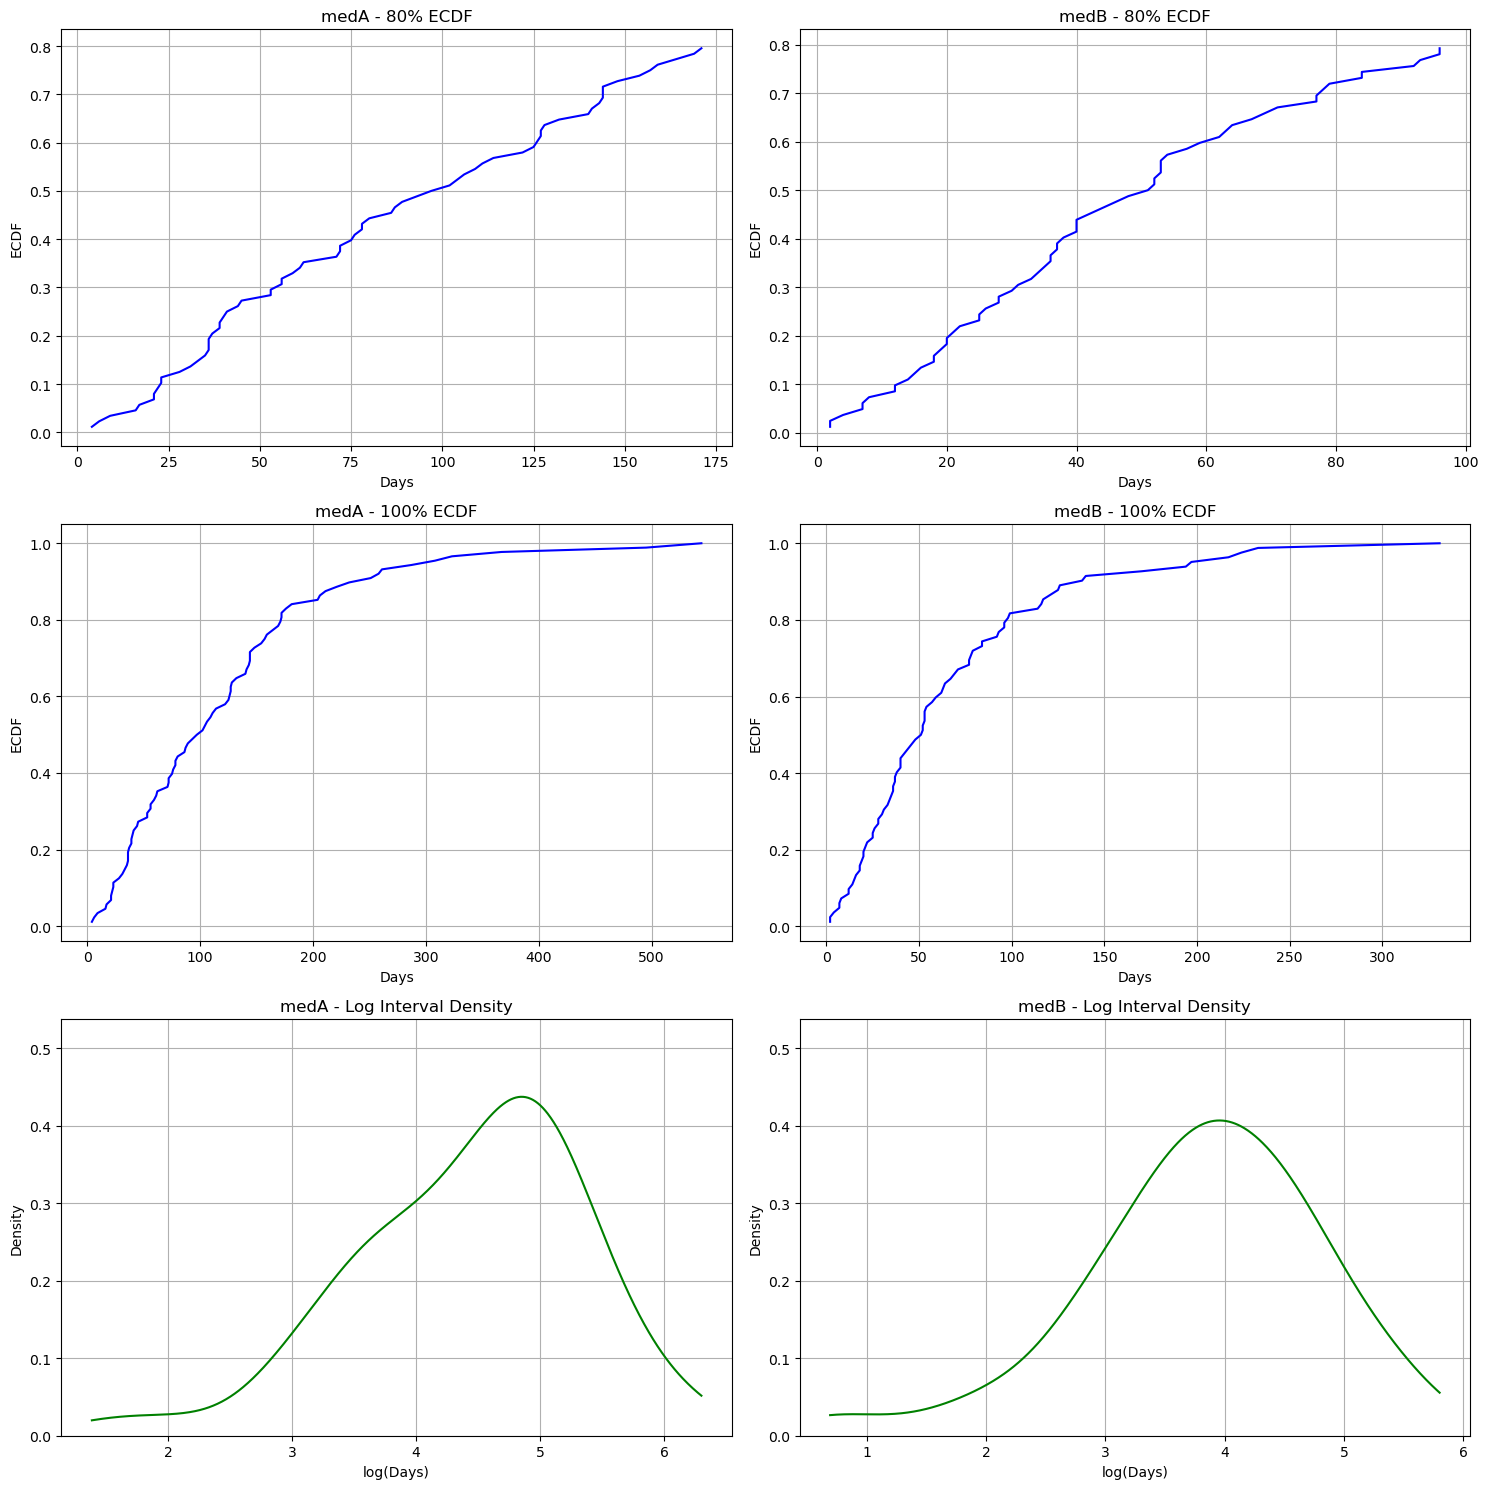

In [16]:
# After generating the data using See()
medA_SEEKmeans = See('medA', tidy)
medB_SEEKmeans = See('medB', tidy)

# Generate visualization
fig = visualization(medA_SEEKmeans, medB_SEEKmeans)
plt.show()

**medA’s** curve is shifted left relative to medB’s, it means medA’s intervals are typically shorter.

**medB’s** curve is more gradual (taking longer to reach 80th percentile), it indicates that a higher fraction of medB intervals extend to larger day values—i.e., medB might have a longer or more spread-out distribution. This could indicated lesser adherence by the patients.

### Comparing 'medA' and 'medB'using DBSCAN

Noise points: 1 (1.43%)
Noise points: 0 (0.00%)


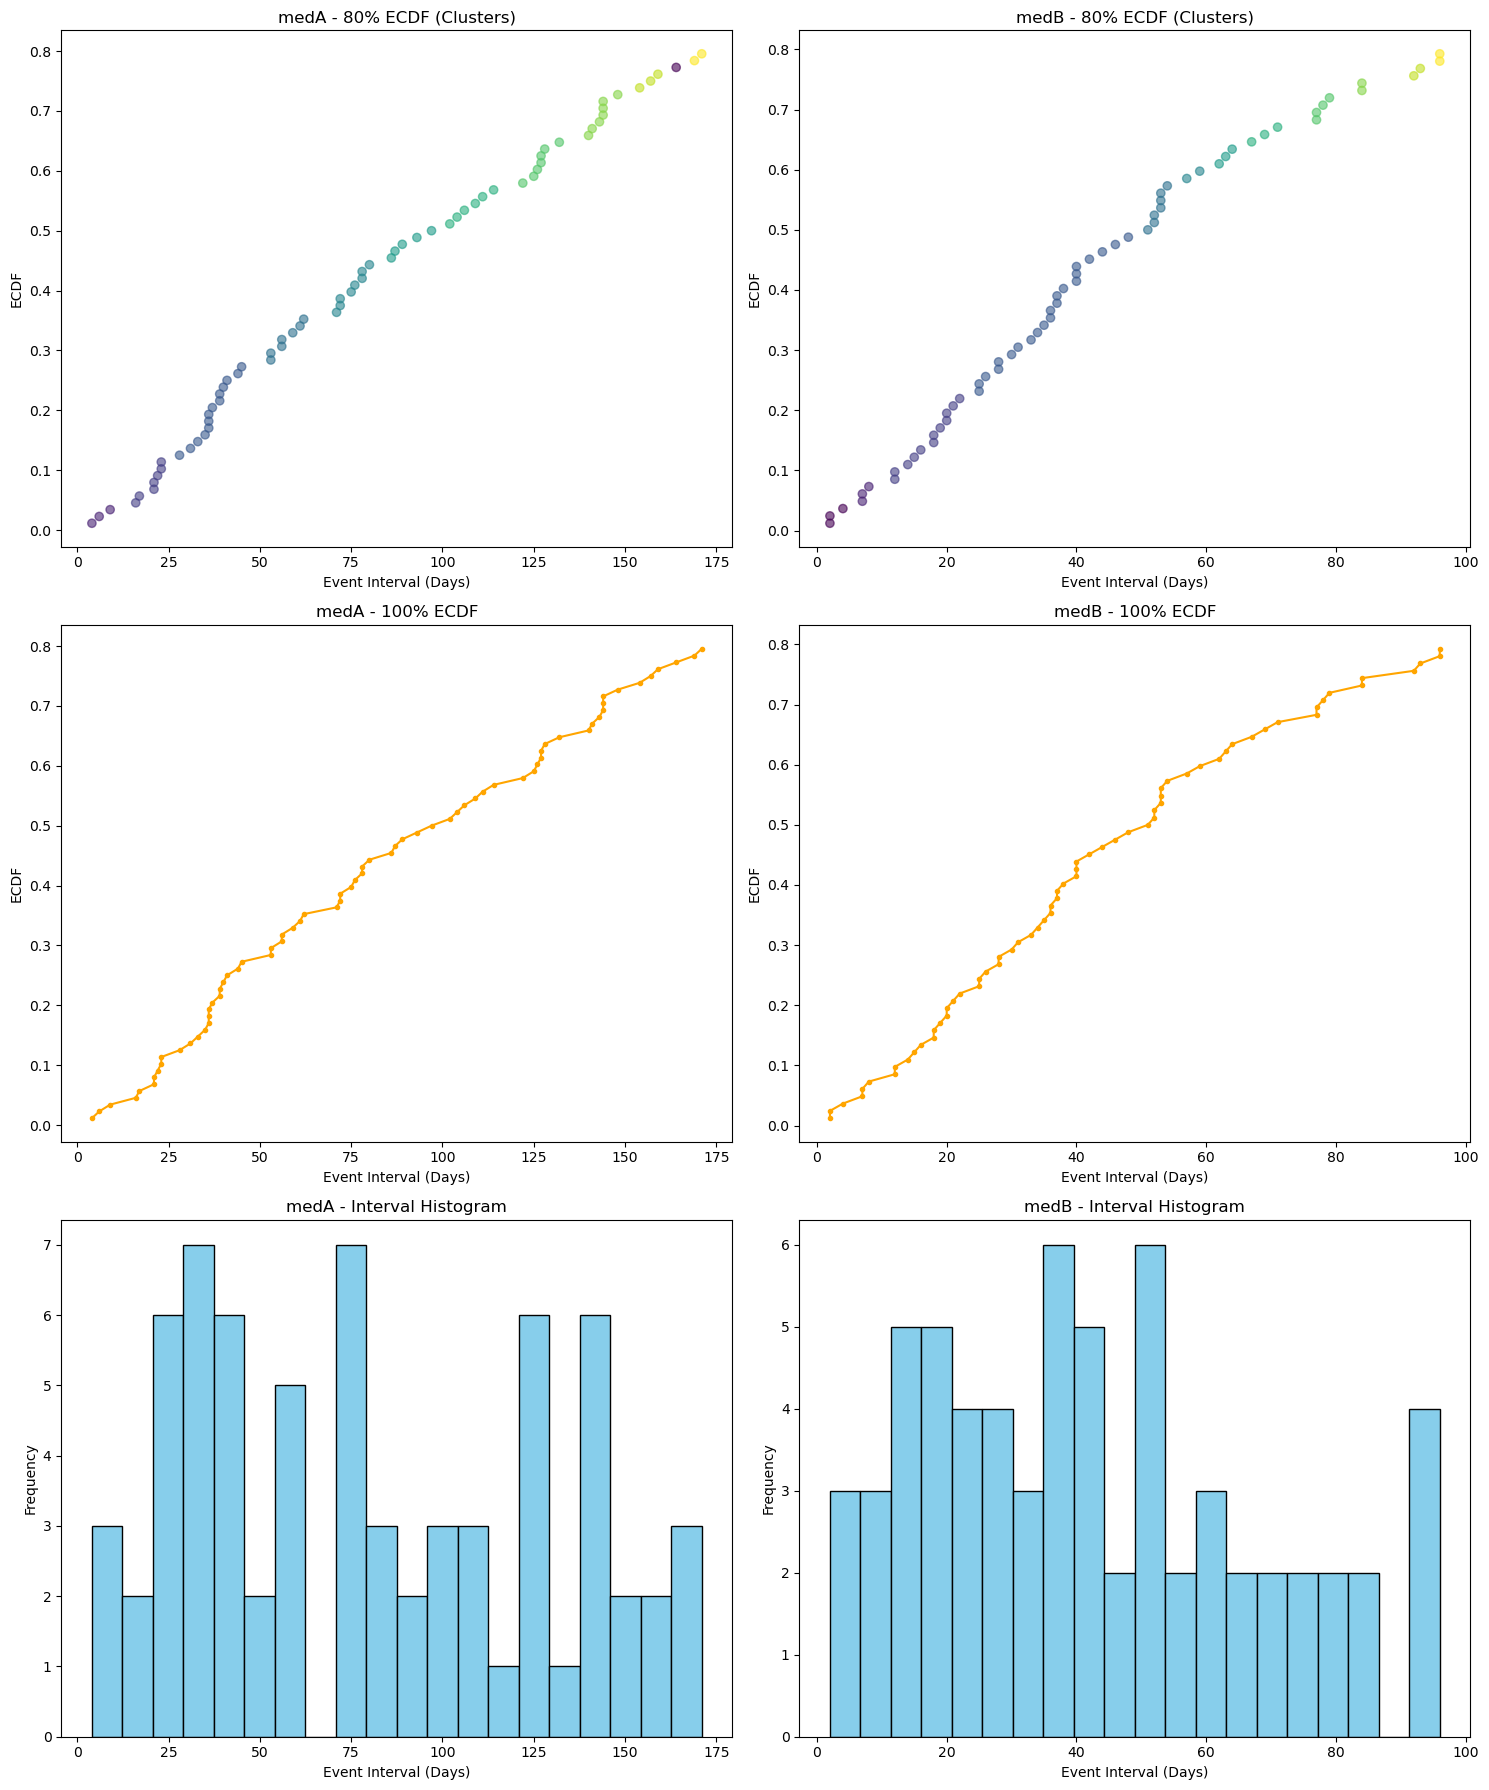

In [29]:
# Process data
medA_results, medA_clusters = See_dbscan('medA', tidy)
medB_results, medB_clusters = See_dbscan('medB', tidy)

# Visualize
fig = visualization_dbscan(medA_clusters, medB_clusters)
plt.show()

Based on the color grouping generated by DBSCAN; it may represent distinct refill or usage pattern.


#### medA's Clusters
**Cluster 1 (short intervals, 0-50 days)**: Patients who refill/return quickly.

**Cluster 2 (medium intervals, 50-110 days)**: Patients who have moderate gaps.

**Cluster 3 (long intervals, 110+ days)**: Patients with lengthy gaps or more sporadic usage.

#### medB's Clusters
**Cluster 1 (short intervals, 0-25 days)**: Patients who refill/return quickly.

**Cluster 2 (medium intervals, 25-50 days)**: Patients who have moderate gaps.

**Cluster 3 (long intervals, 60-100+ days)**: Patients with lengthy gaps or more sporadic usage.

medA exhibits a wider and more variable refill pattern, indicating inconsistent usage behavior among patients, whereas medB shows a more compact and structured refill pattern, suggesting more regular adherence. The distribution of event intervals implies that medB has steadier regimen, while medA have more sporadic refill habits. These differences may provide insight into the potency, adherence, or effectiveness of each medication.

## **Assumption Testing: Prescription Interval Analysis**

This function examines prescription patterns over time using boxplots.

### Code

In [18]:
def see_assumption(arg1):
    """
    Analyze prescription patterns over time with boxplots
    
    Parameters:
    arg1 (pd.DataFrame): DataFrame containing prescription data
    
    Returns:
    matplotlib.figure.Figure: Boxplot visualization
    """
    # Sort and create lagged column
    arg1 = (arg1.sort_values(['pnr', 'eksd'])
            .groupby('pnr')
            .apply(lambda x: x.assign(prev_eksd=x['eksd'].shift(1)))
            .reset_index(drop=True))
    
    # Create sequence numbers
    drug_see2 = (arg1.groupby('pnr')
                 .apply(lambda x: x.assign(p_number=list(range(1, len(x) + 1))))
                 .reset_index(drop=True))
    
    # Filter for p_number >= 2
    drug_see2 = drug_see2[drug_see2['p_number'] >= 2]
    
    # Select required columns
    drug_see2 = drug_see2[['pnr', 'eksd', 'prev_eksd', 'p_number']]
    
    # Calculate duration
    drug_see2['Duration'] = (drug_see2['eksd'] - drug_see2['prev_eksd']).dt.days
    
    # Convert p_number to string for plotting
    drug_see2['p_number'] = drug_see2['p_number'].astype(str)
    
    # Calculate median of medians
    medians_of_medians = (drug_see2.groupby('pnr')['Duration']
                         .median()
                         .median())
    

### Visualization Function

In [19]:
def prepare_prescription_data(df):

    # Sort, create lagged column
    df = (df.sort_values(['pnr', 'eksd'])
          .groupby('pnr')
          .apply(lambda x: x.assign(prev_eksd=x['eksd'].shift(1)))
          .reset_index(drop=True))
    
    # Create sequence numbers
    df = (df.groupby('pnr')
          .apply(lambda x: x.assign(p_number=list(range(1, len(x) + 1))))
          .reset_index(drop=True))
    
    # Filter for p_number >= 2
    df = df[df['p_number'] >= 2]
    
    # Select required columns
    df = df[['pnr', 'eksd', 'prev_eksd', 'p_number']]
    
    # Calculate duration (days)
    df['Duration'] = (df['eksd'] - df['prev_eksd']).dt.days
    
    # Convert p_number to string for plotting
    df['p_number'] = df['p_number'].astype(str)
    
    # Calculate median of medians (patient-level)
    medians_of_medians = (df.groupby('pnr')['Duration']
                          .median()
                          .median())
    
    return df, medians_of_medians

def plot_prescription_boxplot(data, median_of_medians, ax, title=None):

    sns.boxplot(x='p_number', y='Duration', data=data, ax=ax)
    # Add horizontal line for the median of medians
    ax.axhline(y=median_of_medians, color='red', linestyle='--', 
               label=f'Median of medians: {median_of_medians:.1f}')
    ax.set_xlabel('Prescription Number')
    ax.set_ylabel('Duration (days)')
    if title:
        ax.set_title(title)
    ax.legend()

def see_assumption_side_by_side(dfA, dfB):
    # Prepare data for each dataset
    dataA, medianA = prepare_prescription_data(dfA)
    dataB, medianB = prepare_prescription_data(dfB)
    
    # Create subplots side by side
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)
    
    # Plot for medA
    plot_prescription_boxplot(dataA, medianA, axes[0], title='medA - Boxplot')
    
    # Plot for medB
    plot_prescription_boxplot(dataB, medianB, axes[1], title='medB - Boxplot')
    
    plt.tight_layout()
    return fig

# Usage:
# fig = see_assumption_side_by_side(medA_SEEKmeans, medB_SEEKmeans)
# plt.show()  # or fig.show()


### Comparing Prescription Interval Analysis: medA vs medB

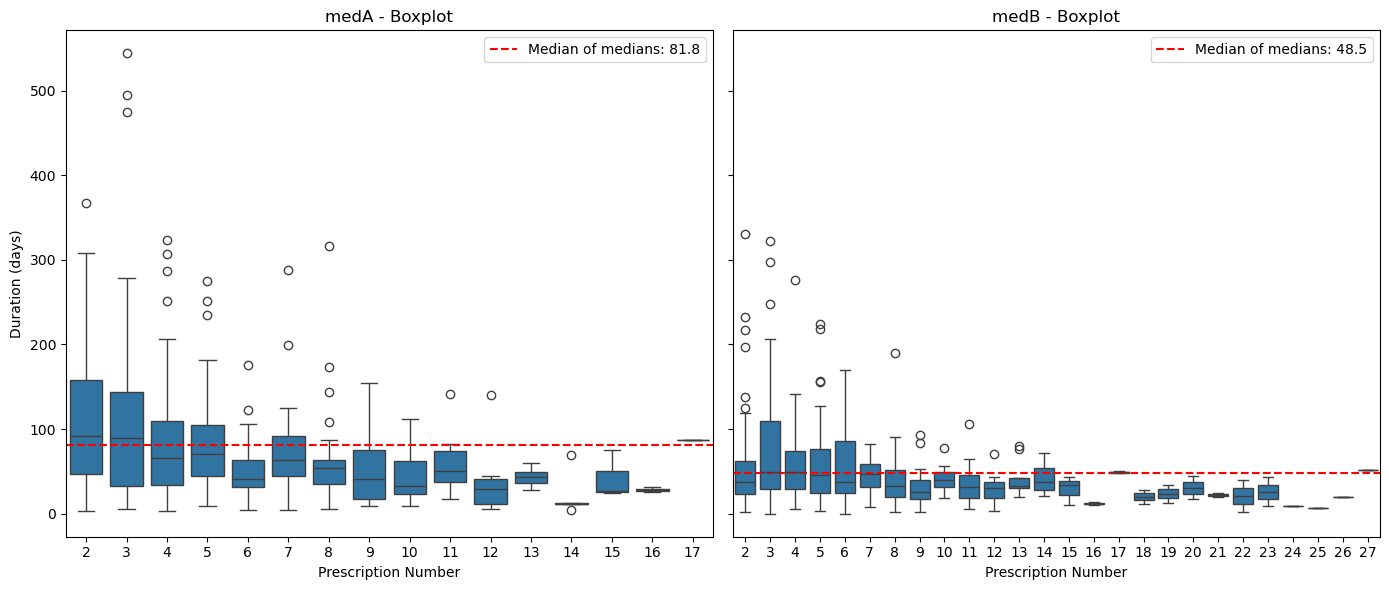

In [20]:
# Visualize together
fig = see_assumption_side_by_side(medA_SEEKmeans, medB_SEEKmeans)
plt.show()

#### Insights

- medA: The dashed red line is around 81.8 days.
- medB: The dashed red line is around 48.5 days.

This indicates that, on average, medA has longer intervals between prescriptions than medB. If you think of the median of medians as a rough “typical” refill gap, patients on medA might be refilling or returning less frequently.

**The height of the Boxes** indicates that there is more variability in refill times for that prescription number. Specific to medA, it seems that there is more variability in P#'s 2 and 3.

**Outliers**. medA seems to produce more outliers, evident by the dots outside the 'whiskers' of the boxes. This indicates that some patients have much longer gaps between refills/returns.

# Insights in K-Means vs DBSCAN
### **K-Means Insights**

**Predefined Number of Clusters**: K-means by nature, requires us to identify the number of clusters (e.g., 3). This can be helpful if we already know or assume how many subgroups exist. This is an issue if we do not.

**Global Partition:** Every data point is assigned to one of the clusters—there’s no concept of “noise” or outliers.

*Takeaway: K-Means forced the data into a fixed number of clusters, making it straightforward to compare overall “typical” usage patterns (like short vs. long intervals) across meds. However, it may not capture smaller, denser subgroups or outliers naturally.*

### DBSCAN Insights


**Density-Based:** DBSCAN finds clusters by identifying dense regions. Unlike K-means, DBSCAN doesn’t require you to specify the number of clusters.

**Outliers/Noise:** DBSCAN can label points as noise (-1), which is useful if some intervals are very large or very small and don’t fit the main usage patterns.

**Natural Subpopulations:** By allowing DBSCAN to do its work, it revealed natural subpopulation within he data that otherwise might have been hard to distinguish.
#### medA's Clusters
- **Cluster 1 (short intervals, 0-50 days)**: Patients who refill/return quickly.

- **Cluster 2 (medium intervals, 50-110 days)**: Patients who have moderate gaps.

- **Cluster 3 (long intervals, 110+ days)**: Patients with lengthy gaps or more sporadic usage.

#### medB's Clusters
- **Cluster 1 (short intervals, 0-25 days)**: Patients who refill/return quickly.

- **Cluster 2 (medium intervals, 25-50 days)**: Patients who have moderate gaps.

- **Cluster 3 (long intervals, 60-100+ days)**: Patients with lengthy gaps or more sporadic usage.

*Takeaway: DBSCAN reveals natural clusters of refill intervals and can highlight outliers or minority patterns that K-Means might lump into a larger cluster. In the case of this data, it underscores how medA usage is more tightly clustered around shorter intervals, while medB has a subgroup of patients with significantly longer intervals.*
